In [35]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T133959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7bae8d3b3a1ab825cad7cc2bdc124fc527e8ca00c1f70f825b37daca041b74dca5b748b60e33a29a574c2130723f5e7762c37782f8a242300d92ca0c5d8b95f65c1bbcfa97fc374161fa91d2ccce3b5a95fafd6974e0bad53e8f2c90d0e9000e8585a7c8df1ee6e65f3406fc906d3010799cb20d38f0038dd24476b47348a33875882f559c8b28b7620f12412e7bbb1efc1c0ca54d48b8dfc26487d6eb3e0f716f7edbc7cec73d758782a8789e04c54fafc5e54abd37cc6b4776a64689873df5b7a746a362e2fbfd291354b431031e9433c482eb8dcb4cf264c98a92261b5174bce154004b0a6d2512e22276b5b6353bfbf390d6433ee0a4f910115eab599429,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T133959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbd4ec0c0d76c795a6911c5c475f43ebd5c262b4a3b90eebcece9c0f5d693d7d308ffacafd9786c02a6d117630943f05dd65810580c874fa6cd9de2ecded516ed73193da0411bc0967cf95c7918ac750438dd9e40d016ab7c281a8633a815b46144409c04b2fe97cf250f5109f07a4ef20f4c8f67dcccf8ead96c02c1984c0675b148aad09f6a46aedcdea1e55931a1565f06e5102cd7dcc66cf826332655347c8f40af98ceea4e198a26b4df98245fe77649667b3083e5c09604e5dc37ec728749377f17ad0395890489d3df0af180afbefbdd23cabfa75bb31f70ec8ab10aa2ddead4d2cc26df84b3b9e77af672c4e2ee78fae30ca93a236abc22ce12713b0c,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T133959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D75efba6817a3e7e708b557b3590978e794a2d1e5f65863781220abcb4b85dab40bd5b9de7461ef99d416adc7a8c5f4dfb5a2da3d9177f785bee601d8256f43109da11690d6e8712499e93434657a0ed457391e70aa06f62bb676dd9e59bbe7e381eb31d5cd8a6a169524f4a8bf20d0ba997a5394871b6d1da49f1da5b60ad1ea042270ad7455093a89c695f7d0d7b480896ecc64c22545eb487d478fb51a647097ea5dd6564fbb1fe3a56e336eba26bc355c33e1a32bb5188f7537f31bd29e3f475c289231a79970f86b514dc2aa27d1b0413635390a022725dbd480830fe6ef55f83052a4b2e50e3b50463ece45e6ad76c672555fd5c4a8f04c128caeb046ff,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T133959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc1d40cdc0942e6b35bb7f5d3ce2b6ebac58f1c2617b9500a38f812db9be04b30ce05f08e826c77d44a6dbd04efef512531c930a915c4f9a12a24d1b08a0550ccba0e7f6237cb9bccd788ba4f7fe8910e919834106b42cd2eb430293f879cfde301692647a41bb58e50d5e532deb65811ab4c2ef222bc63d352a6172054bf2eb55308776882018b616023e7498a4f0f0dbc6fdac82a1a0d42aca33dee9051c8d59329c92c7740406c6312228dab02a06599306b385cd3e25739520e9b42dc1120d32334f4c9f96eea988f8a2f0023441bff0b031ef9bf597bbe193a2f829914da74f82a8c0fb0e556bf3ccdad5f6ca7a3e498921fa5b6e171eac85832bb8652a3,speech-signal-features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3468263%2F6060815%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T133959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a6f44ffaf26c2122f7ff26598ddaa131f31492f0664ca5987037500df44ea66915dd1c731d75a284a6a0feb6bcbf184ee708ce8104e06705e0e4361f508ad6ba0656f85929e933b3313b59d947adb27c4add8e948e511d0f046a991c665fd52df08f349ae1cd44f4a1d5ad8ab6b3acf665ce78d0ae183816674818919fa5cb26ba7931c475973bdf15bc2d09cbc9e30d95ad1d5894f5f322e93705374b9dd34ef619c0a3ee8f401bfe50d7b3089930b4666e41b8089d87d1ad8e385705c85fe14d2e75a7160dd967420bcc07940be52e60b538b0c62c033b72a26227ac60767c102c460d70ec74fe9785091d9650444cbb170dd3ba78b2e8e7f804b62dc3f3d'

KAGGLE_INPUT_PATH='/content/input'
KAGGLE_WORKING_PATH='/content/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/content/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
[==================================================] 762345876 bytes downloaded
Downloaded and uncompressed: speech-signal-features
Data source import complete.


In [36]:
# IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Done")


Done


In [37]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

# Importing Data

In [38]:
#preparing data set

ravdess = "/content/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_16', 'Actor_02', 'Actor_06', 'Actor_21', 'Actor_05', 'Actor_20', 'Actor_12', 'Actor_03', 'Actor_01', 'Actor_13', 'Actor_14', 'Actor_17', 'Actor_23', 'Actor_09', 'Actor_24', 'Actor_07', 'Actor_08', 'Actor_19', 'Actor_15', 'Actor_22', 'Actor_18', 'Actor_11', 'Actor_04', 'Actor_10']


In [39]:
Crema = "/content/input/cremad/AudioWAV/"
Tess = "/content/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [40]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [41]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-04-01-01-01-10.wav
03
/content/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-08-02-02-02-16.wav
7
03-01-07-01-01-02-10.wav


In [42]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /content/input/ravdess-emotional-speech-audio/...
1  surprise  /content/input/ravdess-emotional-speech-audio/...
2      fear  /content/input/ravdess-emotional-speech-audio/...
3   disgust  /content/input/ravdess-emotional-speech-audio/...
4     happy  /content/input/ravdess-emotional-speech-audio/...
______________________________________________
      Emotions                                               Path
1435   neutral  /content/input/ravdess-emotional-speech-audio/...
1436       sad  /content/input/ravdess-emotional-speech-audio/...
1437   disgust  /content/input/ravdess-emotional-speech-audio/...
1438  surprise  /content/input/ravdess-emotional-speech-audio/...
1439   disgust  /content/input/ravdess-emotional-speech-audio/...
_______________________________________________
Emotions
neutral     288
surprise    192
fear        192
disgust     192
happy       192
sad         192
angry       192
Name: coun

**Crema DataFrame**

In [43]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
sad        1271
fear       1271
angry      1271
happy      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

In [44]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
surprise    400
happy       400
disgust     400
sad         400
angry       400
neutral     400
fear        400
Name: count, dtype: int64


**SAVEE Dataset**

In [45]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
disgust      60
happy        60
surprise     60
sad          60
angry        60
fear         60
Name: count, dtype: int64


**Integration**

In [46]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/content/input/ravdess-emotional-speech-audio/...
1,surprise,/content/input/ravdess-emotional-speech-audio/...
2,fear,/content/input/ravdess-emotional-speech-audio/...
3,disgust,/content/input/ravdess-emotional-speech-audio/...
4,happy,/content/input/ravdess-emotional-speech-audio/...


In [47]:
import pandas as pd

# Load the dataset
data_path = "data_path.csv"
emotion_df = pd.read_csv(data_path)

# Remove rows with "Surprise" class
emotion_df = emotion_df[emotion_df['Emotions'] != 'surprise']

# Count the number of rows for each class
class_counts = emotion_df['Emotions'].value_counts()

# Remove 300 rows from each class except "happy" and "neutral"
rows_to_keep = []
for emotion, count in class_counts.items():
    if emotion in ['happy', 'neutral']:
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].index)
    else:
        rows_to_keep.extend(emotion_df[emotion_df['Emotions'] == emotion].sample(n=count - 900, random_state=42).index)

# Filter the dataset to keep only the selected rows
emotion_df = emotion_df.loc[rows_to_keep]

# Check the new distribution of emotion classes
print(emotion_df['Emotions'].value_counts())

# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)


Emotions
happy      1923
neutral    1895
fear       1023
disgust    1023
sad        1023
angry      1023
Name: count, dtype: int64


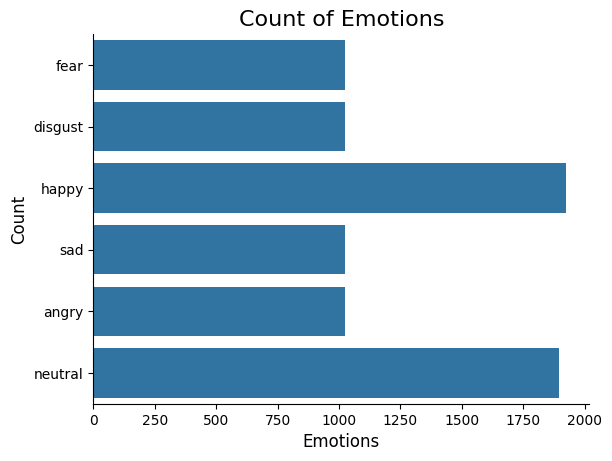

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(emotion_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [49]:
# Save the updated dataset
emotion_df.to_csv("balanced_data.csv", index=False)

In [50]:
data,sr = librosa.load(file_path[0])
sr

22050

In [51]:
ipd.Audio(data,rate=sr)

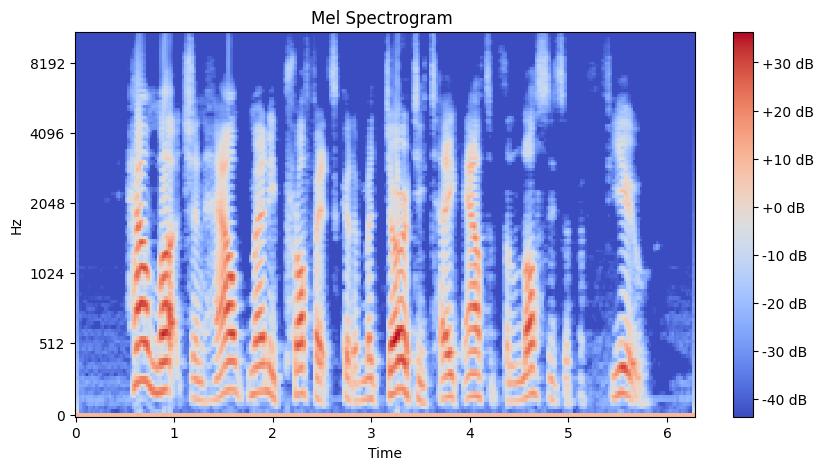

In [52]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

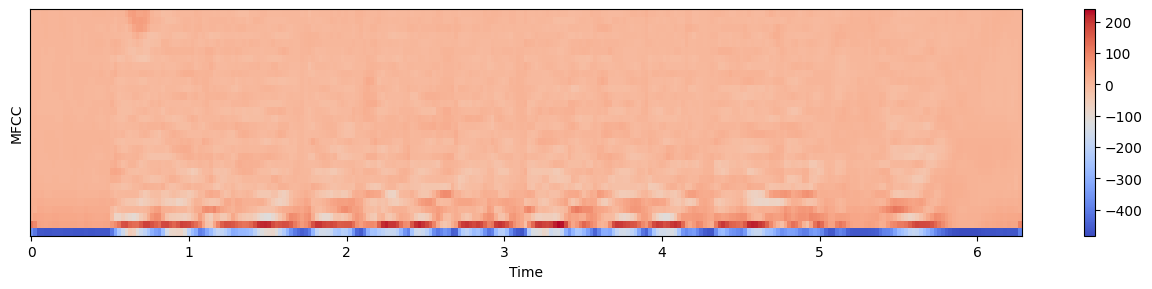

In [53]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [66]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor) # Use keyword arguments for clarity

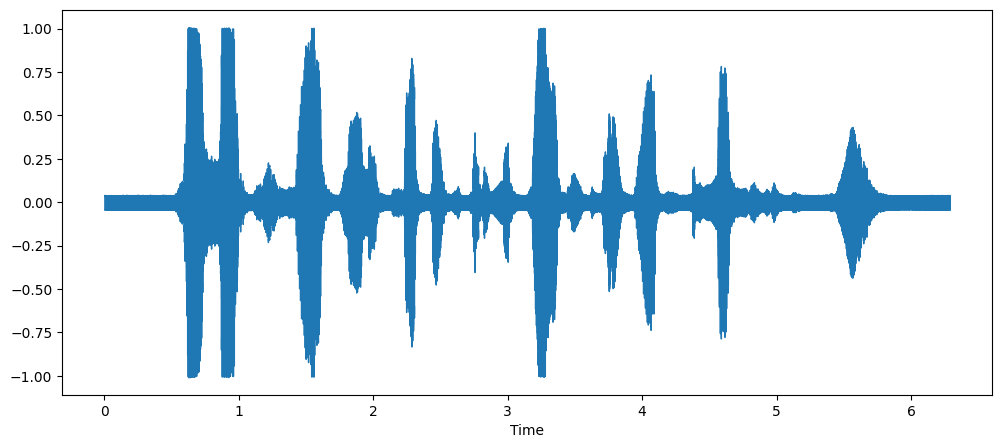

In [67]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

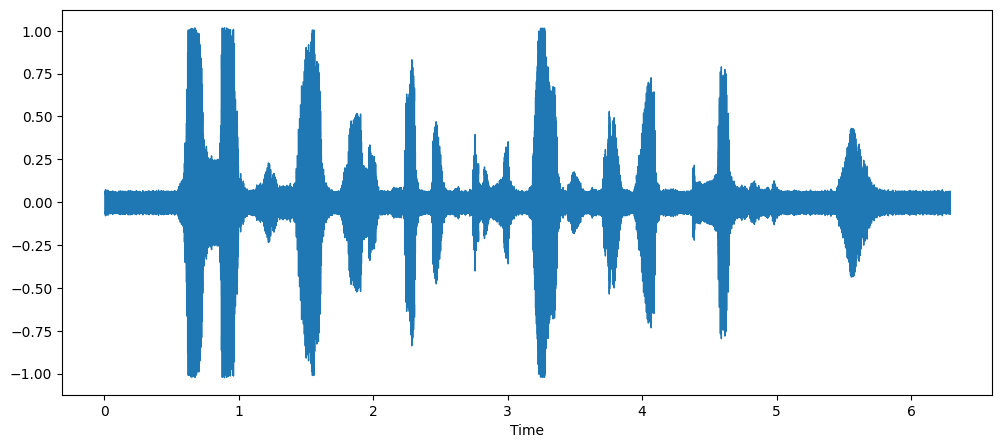

In [68]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

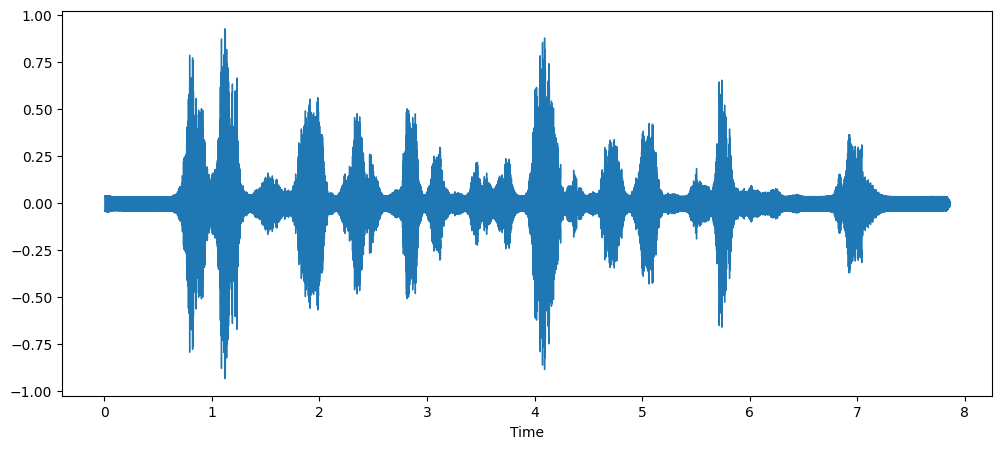

In [69]:
# STRETCHED AUDIO
x = stretch(data, rate=0.8) # Set a value for rate
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

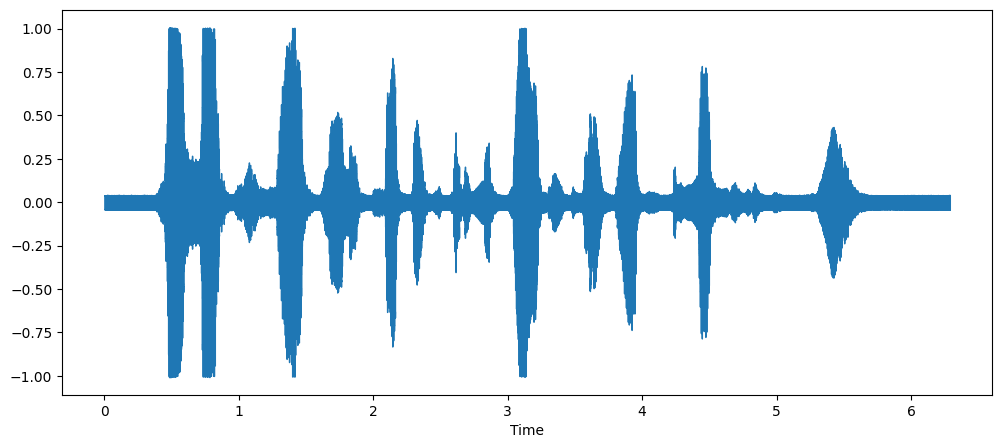

In [70]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

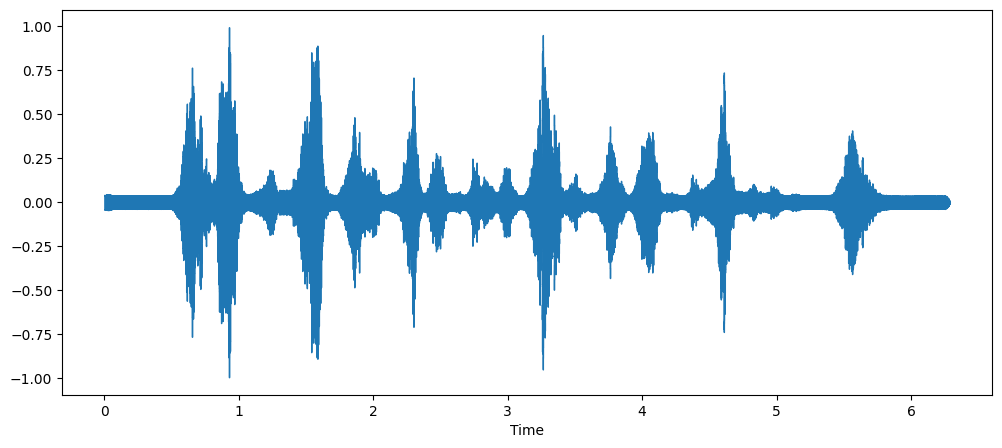

In [71]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [87]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def my_mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    # Use librosa.feature.mfcc inside the custom function
    # Pass data and sr as keyword arguments
    mfccs=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfccs.T)if not flatten else np.ravel(mfccs.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      # Call the renamed custom function my_mfcc
                      my_mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [88]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Features

In [89]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(emotion_df.Path,emotion_df.Emotions,range(emotion_df.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:00,  8.77it/s]

0 audio has been processed


501it [01:04,  7.49it/s]

500 audio has been processed


1001it [02:12,  7.53it/s]

1000 audio has been processed


1502it [03:27,  4.55it/s]

1500 audio has been processed


2002it [04:42,  7.84it/s]

2000 audio has been processed


2501it [05:55,  8.73it/s]

2500 audio has been processed


3002it [07:01,  8.31it/s]

3000 audio has been processed


3502it [08:08,  7.89it/s]

3500 audio has been processed


4002it [09:08,  8.28it/s]

4000 audio has been processed


4502it [10:24,  5.05it/s]

4500 audio has been processed


5002it [11:38,  7.94it/s]

5000 audio has been processed


5502it [12:48,  6.48it/s]

5500 audio has been processed


6001it [13:58,  8.24it/s]

6000 audio has been processed


6502it [15:21,  8.38it/s]

6500 audio has been processed


7001it [16:29,  8.18it/s]

7000 audio has been processed


7502it [17:36,  6.35it/s]

7500 audio has been processed


7910it [18:28,  7.14it/s]

Done
Time:  1108.2726148419997


In [90]:
len(X), len(Y), emotion_df.Path.shape

(31640, 31640, (7910,))

# Saving features

In [91]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.018555,0.024902,0.038574,0.041504,0.049805,0.063477,0.073242,0.084961,0.095215,0.109375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.032227,0.044434,0.056152,0.056152,0.058594,0.066406,0.079102,0.086914,0.099121,0.117188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.017578,0.023438,0.036133,0.037598,0.050781,0.067383,0.073242,0.086426,0.093262,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.018555,0.024414,0.036133,0.036621,0.050781,0.067383,0.074219,0.086426,0.091309,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.022461,0.037109,0.053711,0.052734,0.047852,0.039062,0.030762,0.033203,0.034180,0.041992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [92]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.018555,0.024902,0.038574,0.041504,0.049805,0.063477,0.073242,0.084961,0.095215,0.109375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.032227,0.044434,0.056152,0.056152,0.058594,0.066406,0.079102,0.086914,0.099121,0.117188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.017578,0.023438,0.036133,0.037598,0.050781,0.067383,0.073242,0.086426,0.093262,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.018555,0.024414,0.036133,0.036621,0.050781,0.067383,0.074219,0.086426,0.091309,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.022461,0.037109,0.053711,0.052734,0.047852,0.039062,0.030762,0.033203,0.034180,0.041992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [93]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [94]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(31640, 2377)

In [95]:
np.sum(Emotions.isna())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [96]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [97]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [98]:
print(Y.shape)
X.shape

(31640, 6)


(31640, 2376)

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25312, 2376), (25312, 6), (6328, 2376), (6328, 6))

In [100]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [101]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25312, 2376), (25312, 6), (6328, 2376), (6328, 6))

In [104]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
# import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer #Updated import statement
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [107]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
# If you intend to save the entire model (architecture + weights) use the .keras extension
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

# If you only want to save the model weights, keep the .h5 extension and add the following argument
# model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [108]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [109]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((25312, 2376, 1), (25312, 6), (6328, 2376, 1), (6328, 6))

In [111]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) # Pass 'accuracy' as a list
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9600)                │              

 Total params: 7,192,710 (27.44 MB)

 Trainable params: 7,188,358 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [113]:
history=model.fit(x_traincnn, y_train, epochs=10, validation_data=(x_testcnn, y_test), batch_size=64)

Epoch 1/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 106s 267ms/step - accuracy: 0.5594 - loss: 1.1444 - val_accuracy: 0.5479 - val_loss: 1.1793
Epoch 2/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 141s 265ms/step - accuracy: 0.6192 - loss: 0.9921 - val_accuracy: 0.5427 - val_loss: 1.2214
Epoch 3/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.6630 - loss: 0.8828 - val_accuracy: 0.6515 - val_loss: 0.9225
Epoch 4/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 264ms/step - accuracy: 0.7079 - loss: 0.7736 - val_accuracy: 0.6857 - val_loss: 0.8461
Epoch 5/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 264ms/step - accuracy: 0.7547 - loss: 0.6570 - val_accuracy: 0.7184 - val_loss: 0.7433
Epoch 6/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.8110 - loss: 0.5239 - val_accuracy: 0.7464 - val_loss: 0.6747
Epoch 7/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 266ms/step - accuracy: 0.8552 - loss: 0.4062 - val_accuracy: 0.7886 - val_loss: 0.5874
Epoch 8/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 142s 266ms/step - accuracy: 0.9002 -

198/198 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9162 - loss: 0.2545
Accuracy of our model on test data :  91.57711863517761 %


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

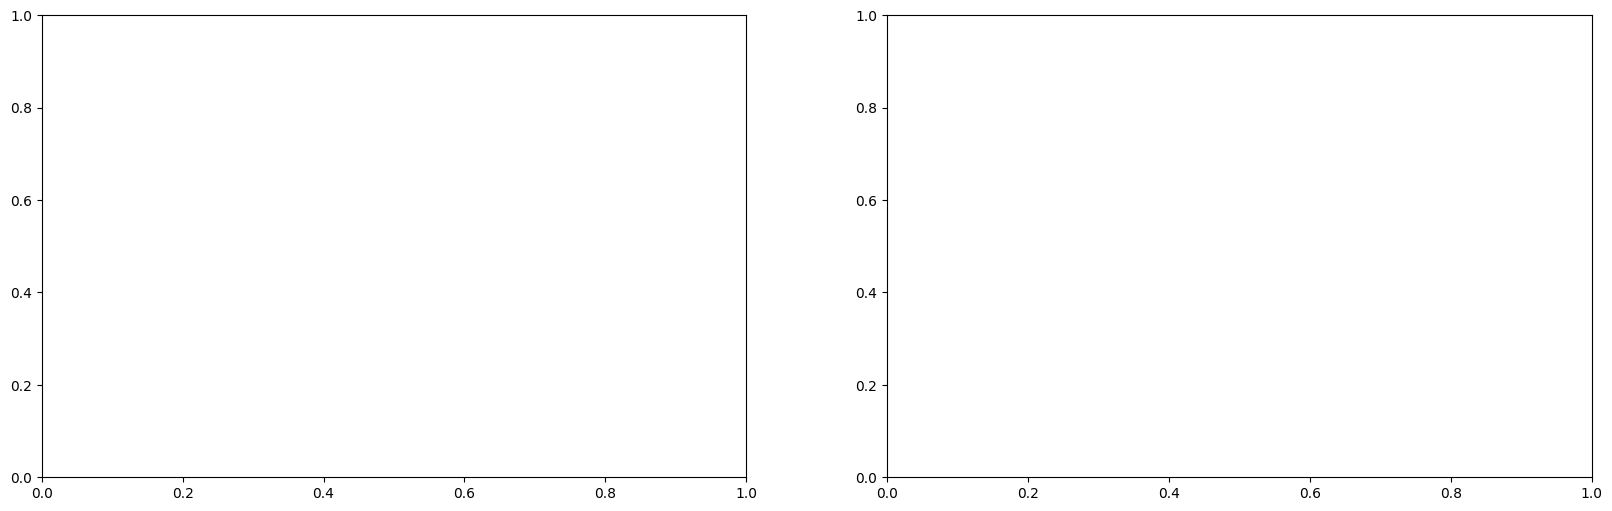

In [114]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [115]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step


In [116]:
df0

,Predicted Labels,Actual Labels
0,fear,fear
1,fear,fear
2,happy,happy
3,angry,angry
4,happy,happy
...,...,...
6323,neutral,neutral
6324,fear,fear
6325,neutral,neutral
6326,neutral,neutral


# Evaluation

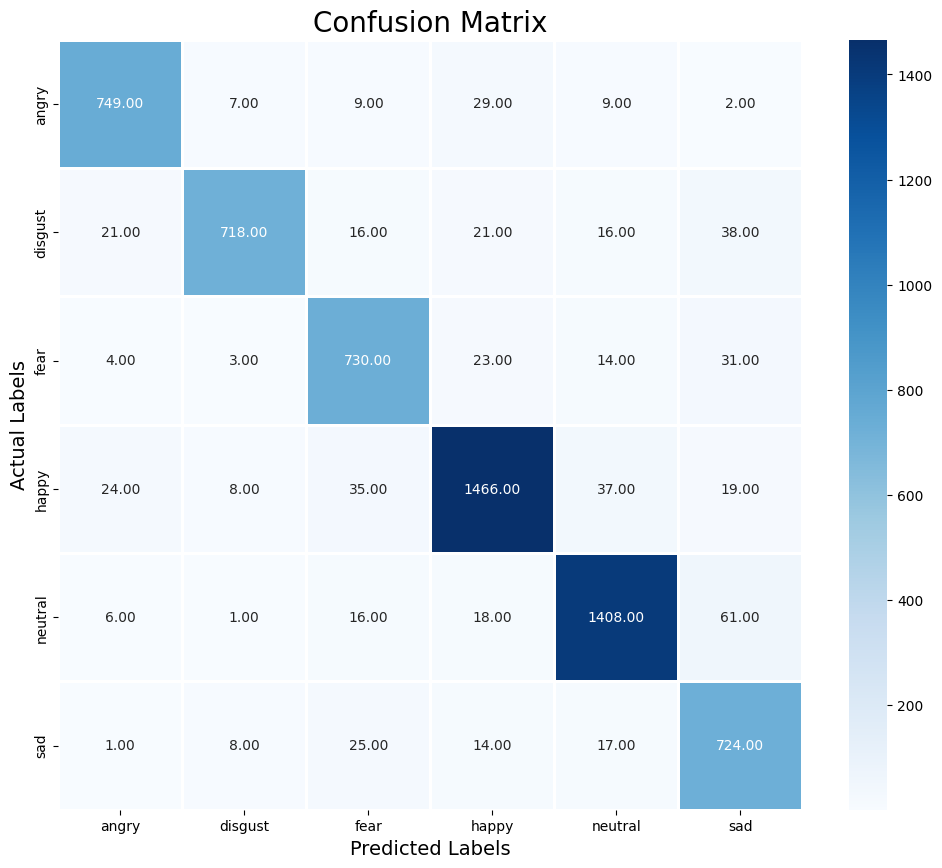

              precision    recall  f1-score   support

       angry       0.93      0.93      0.93       805
     disgust       0.96      0.87      0.91       830
        fear       0.88      0.91      0.89       805
       happy       0.93      0.92      0.93      1589
     neutral       0.94      0.93      0.94      1510
         sad       0.83      0.92      0.87       789

    accuracy                           0.92      6328
   macro avg       0.91      0.91      0.91      6328
weighted avg       0.92      0.92      0.92      6328



In [117]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [119]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.weights.h5") # Added '.weights' to the filename
print("Saved model to disk")

Saved model to disk


In [121]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [122]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9162 - loss: 0.2545
compile_metrics: 91.58%


# Saving and Loading our Standard Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

In [123]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Test script

In [124]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [125]:
import pickle

with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [126]:
import librosa

In [133]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length) # Changed 'data' to keyword argument 'y=data'
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr) # Changed 'data' to keyword argument 'y=data'
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [134]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [135]:
res=get_predict_feat("/content/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [136]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [137]:
prediction("/content/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")
#neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
neutral


In [138]:
prediction("/content/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")
#neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
neutral


In [139]:
prediction("/content/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")
#angry

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
angry


In [140]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")
#sad

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
sad


In [141]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")
#fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
fear


In [143]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
#disgust

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
disgust
